# Environment set up
This section ensures all libraries and data are correctly imported.

### Optional GPU check

In [1]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [0]:
printm()

### Cloning the repository and downloading the data

In [2]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor

Cloning into 'keras_triplet_descriptor'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 181 (delta 0), reused 1 (delta 0), pack-reused 178
Receiving objects: 100% (181/181), 149.87 MiB | 19.97 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Checking out files: 100% (69/69), done.


In [3]:
# Change directory
%cd /content/keras_triplet_descriptor    


/content/keras_triplet_descriptor


In [4]:
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip


--2019-03-22 02:07:52--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 185.235.236.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-22 02:07:52--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-22 02:07:53--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.bo

In [0]:
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

### Importing Necessary Modules

In [6]:
import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams["patch.force_edgecolor"] = True

# To download files
from google.colab import files

Using TensorFlow backend.


# Deploy denoiser

In [0]:
trained_denoiser = keras.models.load_model('./denoise_dcnn_full11b.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# Train baseline Descriptor on clean patches
To identify the upper bound performance of the baseline descriptor model as well as to gather qualitative insights on the network's output.

## Instantiate baseline descriptor model

### Load clean hpatches data

In [0]:
# Initialise random seeds for reproducibility
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Import and read hpatches dataset
hpatches_dir = './hpatches'
splits_path = './splits.json'
splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']
train_fnames = split['train']
test_fnames = split['test']
seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))


In [0]:
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames, use_clean=True)

### Define model and loss

In [0]:
# Original L2-Net Baseline
def get_baseline_descriptor(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model

In [0]:
# Original triplet loss
def baseline_triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

### Create online generators

In [0]:
# Initialise random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Define baseline batch size and number of triplets
gen_batch_size = 50
trn_triplets = 100000
val_triplets =  10000

# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=trn_triplets)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=val_triplets)


Using clean patches
100%|██████████| 116/116 [00:33<00:00,  2.82it/s]


100%|██████████| 100000/100000 [00:01<00:00, 69448.02it/s]


Using clean patches
100%|██████████| 116/116 [00:20<00:00,  5.74it/s]


100%|██████████| 10000/10000 [00:00<00:00, 59463.98it/s]


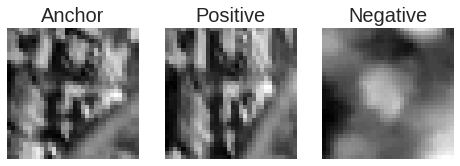

In [0]:
# Plot an example of triplet
plot_triplet(training_generator)

### Compile model

In [0]:
# Initialise random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Define the three input layers
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')

# Create the siamese models
baseline_descriptor_model = get_baseline_descriptor(shape)
ea = baseline_descriptor_model(xa)
ep = baseline_descriptor_model(xp)
en = baseline_descriptor_model(xn)

# Generate the triplet model
loss = Lambda(baseline_triplet_loss)([ea, ep, en])
baseline_descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)

# Compile model: SGD is rejected in favour of Adam even in the baseline model
adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=True)
baseline_descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=adm)

# Initialise lists to record training history
baseline_loss = []
baseline_val = []
baseline_epo = []
bs_epoch_count = 1

In [0]:
# Print a summary of the triplet model
baseline_descriptor_model_trip.summary()

## Train model

### Train and save model - Epoch 1
We obvserve running time and initial loss after the first epoch.

In [0]:
# Train first epoch
print('Epoch number',bs_epoch_count)
baseline_descriptor_hist = baseline_descriptor_model_trip.fit_generator(
                                                    generator=training_generator,
                                                    epochs=1, verbose=1,
                                                    validation_data=val_generator)
baseline_epo.append(bs_epoch_count)
baseline_loss.append(baseline_descriptor_hist.history['loss'])
baseline_val.append(baseline_descriptor_hist.history['val_loss'])
bs_epoch_count += 1

# Save models
baseline_descriptor_model_trip.save('bs_trip_descriptor_e1.h5')
baseline_descriptor_model.save('bs_descriptor_e1.h5')
!curl -F "file=@bs_trip_descriptor_e1.h5" https://file.io
!curl -F "file=@bs_descriptor_e1.h5" https://file.io

('Epoch number', 1)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2038

100%|██████████| 100000/100000 [00:03<00:00, 27345.47it/s]


2000/2000 [==============================] - 187s 94ms/step - loss: 0.2038 - val_loss: 0.1890
{"success":true,"key":"3TUCLq","link":"https://file.io/3TUCLq","expiry":"14 days"}{"success":true,"key":"ZhdBOs","link":"https://file.io/ZhdBOs","expiry":"14 days"}

### Train and save model - Epoch 5

In [0]:
for e in range(4):
  print('Epoch number',bs_epoch_count)
  
  baseline_descriptor_hist = baseline_descriptor_model_trip.fit_generator(
      generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  
  baseline_epo.append(bs_epoch_count)
  baseline_loss.append(baseline_descriptor_hist.history['loss'])
  baseline_val.append(baseline_descriptor_hist.history['val_loss'])
  bs_epoch_count += 1

# Save models
baseline_descriptor_model_trip.save('bs_trip_descriptor_e5.h5')
baseline_descriptor_model.save('bs_descriptor_e5.h5')
!curl -F "file=@bs_trip_descriptor_e5.h5" https://file.io
!curl -F "file=@bs_descriptor_e5.h5" https://file.io
  
# Print loss curves
print('Epochs',baseline_epo)
print('Loss', baseline_loss)
print('Val',baseline_val)

('Epoch number', 2)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1263

100%|██████████| 100000/100000 [00:03<00:00, 27412.30it/s]


2000/2000 [==============================] - 177s 88ms/step - loss: 0.1262 - val_loss: 0.1562
('Epoch number', 3)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1139

100%|██████████| 100000/100000 [00:03<00:00, 29031.63it/s]


2000/2000 [==============================] - 177s 88ms/step - loss: 0.1139 - val_loss: 0.1298
('Epoch number', 4)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1000

100%|██████████| 100000/100000 [00:04<00:00, 21855.52it/s]


2000/2000 [==============================] - 178s 89ms/step - loss: 0.1000 - val_loss: 0.1145
('Epoch number', 5)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0897

100%|██████████| 100000/100000 [00:03<00:00, 27346.04it/s]


2000/2000 [==============================] - 178s 89ms/step - loss: 0.0896 - val_loss: 0.1101
{"success":true,"key":"RvLkSP","link":"https://file.io/RvLkSP","expiry":"14 days"}{"success":true,"key":"PqhInI","link":"https://file.io/PqhInI","expiry":"14 days"}('Epochs', [1, 2, 3, 4, 5])
('Loss', [[0.20375348175376712], [0.12624182823907176], [0.11385689811104152], [0.09996190780464895], [0.08964496588223847]])
('Val', [[0.1890304999984801], [0.15621989610459422], [0.12979786690673792], [0.11447668469743803], [0.11011563445208594]])


### Train and save model - Epoch 20

In [0]:
for e in range(15):
  print('Epoch number',bs_epoch_count)
  
  baseline_descriptor_hist = baseline_descriptor_model_trip.fit_generator(
      generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  
  baseline_epo.append(bs_epoch_count)
  baseline_loss.append(baseline_descriptor_hist.history['loss'])
  baseline_val.append(baseline_descriptor_hist.history['val_loss'])
  bs_epoch_count += 1

# Save models
baseline_descriptor_model_trip.save('bs_trip_descriptor_e20.h5')
baseline_descriptor_model.save('bs_descriptor_e20.h5')
!curl -F "file=@bs_trip_descriptor_e20.h5" https://file.io
!curl -F "file=@bs_descriptor_e20.h5" https://file.io
  
# Print loss curves
print('Epochs',baseline_epo)
print('Loss', baseline_loss)
print('Val',baseline_val)

('Epoch number', 6)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0774

100%|██████████| 100000/100000 [00:03<00:00, 27373.61it/s]


2000/2000 [==============================] - 177s 89ms/step - loss: 0.0774 - val_loss: 0.1096
('Epoch number', 7)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0748

100%|██████████| 100000/100000 [00:03<00:00, 28913.38it/s]


2000/2000 [==============================] - 176s 88ms/step - loss: 0.0748 - val_loss: 0.1169
('Epoch number', 8)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0670

100%|██████████| 100000/100000 [00:03<00:00, 28409.79it/s]


2000/2000 [==============================] - 176s 88ms/step - loss: 0.0670 - val_loss: 0.0963
('Epoch number', 9)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0653

100%|██████████| 100000/100000 [00:03<00:00, 29365.07it/s]


2000/2000 [==============================] - 176s 88ms/step - loss: 0.0653 - val_loss: 0.1000
('Epoch number', 10)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0662

100%|██████████| 100000/100000 [00:03<00:00, 27736.00it/s]


2000/2000 [==============================] - 177s 88ms/step - loss: 0.0663 - val_loss: 0.0887
('Epoch number', 11)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0572

100%|██████████| 100000/100000 [00:04<00:00, 22279.27it/s]


2000/2000 [==============================] - 177s 89ms/step - loss: 0.0572 - val_loss: 0.1110
('Epoch number', 12)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0618

100%|██████████| 100000/100000 [00:03<00:00, 28499.19it/s]


2000/2000 [==============================] - 177s 89ms/step - loss: 0.0618 - val_loss: 0.1010
('Epoch number', 13)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0555

100%|██████████| 100000/100000 [00:03<00:00, 28035.26it/s]


2000/2000 [==============================] - 177s 88ms/step - loss: 0.0555 - val_loss: 0.0864
('Epoch number', 14)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0555

100%|██████████| 100000/100000 [00:03<00:00, 29135.94it/s]


2000/2000 [==============================] - 176s 88ms/step - loss: 0.0555 - val_loss: 0.0963
('Epoch number', 15)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0521

100%|██████████| 100000/100000 [00:03<00:00, 28367.89it/s]


2000/2000 [==============================] - 177s 89ms/step - loss: 0.0521 - val_loss: 0.0909
('Epoch number', 16)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0588

100%|██████████| 100000/100000 [00:03<00:00, 27399.01it/s]


2000/2000 [==============================] - 177s 88ms/step - loss: 0.0588 - val_loss: 0.0947
('Epoch number', 17)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0525

100%|██████████| 100000/100000 [00:03<00:00, 28533.68it/s]


2000/2000 [==============================] - 176s 88ms/step - loss: 0.0524 - val_loss: 0.0952
('Epoch number', 18)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0540

100%|██████████| 100000/100000 [00:04<00:00, 22711.76it/s]


2000/2000 [==============================] - 177s 88ms/step - loss: 0.0541 - val_loss: 0.0869
('Epoch number', 19)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0494

100%|██████████| 100000/100000 [00:03<00:00, 27402.02it/s]


2000/2000 [==============================] - 181s 91ms/step - loss: 0.0494 - val_loss: 0.0798


100%|██████████| 10000/10000 [00:00<00:00, 61407.77it/s]


('Epoch number', 20)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0484

100%|██████████| 100000/100000 [00:03<00:00, 27770.80it/s]


2000/2000 [==============================] - 179s 89ms/step - loss: 0.0484 - val_loss: 0.0831
{"success":true,"key":"6otRfC","link":"https://file.io/6otRfC","expiry":"14 days"}{"success":true,"key":"uUJYoA","link":"https://file.io/uUJYoA","expiry":"14 days"}('Epochs', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
('Loss', [[0.20375348175376712], [0.12624182823907176], [0.11385689811104152], [0.09996190780464895], [0.08964496588223847], [0.07738297405181584], [0.07480863291910646], [0.06696327244347049], [0.06532479770145619], [0.06626588492320479], [0.05716229805073635], [0.06180751825054722], [0.05546622675077015], [0.05546771268250086], [0.05212180319649815], [0.05879474075542885], [0.052441509388472696], [0.05406738201301778], [0.0494032579374234], [0.04835177053282405]])
('Val', [[0.1890304999984801], [0.15621989610459422], [0.12979786690673792], [0.11447668469743803], [0.11011563445208594], [0.10961331890663133], [0.11694466379005462], [0.096325404431263

## Rubbish

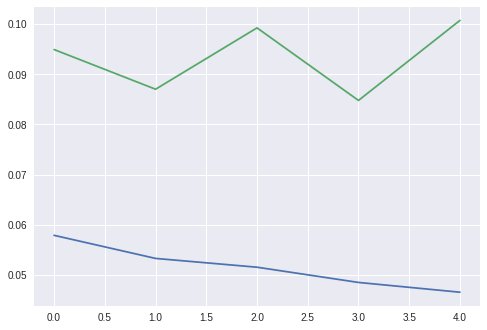

In [0]:
plt.plot(descriptor_history_xl.history['loss'])
plt.plot(descriptor_history_xl.history['val_loss'])

In [0]:
# Increase batch size to avoid reducing learning rate, also increase number of triplets exposed to the network
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)


### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames, use_clean=True)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=1000000,batch_size = 200)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=100000,batch_size = 200)


Using clean patches
100%|██████████| 116/116 [00:36<00:00,  3.22it/s]


100%|██████████| 1000000/1000000 [00:14<00:00, 68118.64it/s]


Using clean patches
100%|██████████| 116/116 [00:21<00:00,  5.44it/s]


100%|██████████| 100000/100000 [00:01<00:00, 62471.66it/s]


In [0]:
descriptor_history_xl = descriptor_model_trip.fit_generator(generator=training_generator, epochs=5, verbose=1, validation_data=val_generator)

## Further training

In [0]:
lol = hPatches.read_image_file(hpatches_dir, train=1)

In [0]:
np.shape(lol[1])

(1558960,)

In [0]:
np.shape(lol[0])

(1558960, 32, 32)

In [0]:
np.shape(lol[0][:10,:,:])

(10, 32, 32)

In [0]:
mol = tf.convert_to_tensor(np.random.rand(100,128))
print(mol.shape)
D = _pairwise_distances(mol, False)

In [0]:
np.mean(lol[0], axis = 0)

In [0]:
generator = DenoiseHPatches(['./hpatches/v_there'])
imgs, imgs_clean = next(iter(generator))
index = np.random.randint(0, imgs.shape[0])


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


In [0]:
a = next(iter(val_small_generator))

In [0]:
b = next(iter(val_small_generator))

In [0]:
b[1]

In [0]:
a[0]['p'].shape

(2000, 32, 32, 1)

# Train T/Np Loss descriptor on clean patches
To evaluate performance improvement due to using the T/Np loss on the clean HPatches.

## Instantiate baseline descriptor model

### Load clean hpatches data

In [0]:
# Initialise random seeds for reproducibility
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Import and read hpatches dataset
hpatches_dir = './hpatches'
splits_path = './splits.json'
splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']
train_fnames = split['train']
test_fnames = split['test']
seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))


In [0]:
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames, use_clean=True)

### Define model and loss

In [0]:
# DnCNN denoiser block
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract
from keras.models import Model, load_model

def DnCNN(shape):
  
  depth   = 17
  filters = 64
  # Input definition
  layer_count = 0
  inpt = Input((32,32,1), name = 'input'+str(layer_count))
  
  
  # 1st layer, Conv+relu
  layer_count += 1
  x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'conv'+str(layer_count))(inpt)
  layer_count += 1
  x = Activation('relu',name = 'relu'+str(layer_count))(x)
  
  # depth-2 layers, Conv+BN+relu
  for i in range(depth-2):
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
    layer_count += 1
    x = Activation('relu',name = 'relu'+str(layer_count))(x)   
    layer_count += 1
    x = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
      
  # last layer, Conv
  layer_count += 1
  x = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
  layer_count += 1
  x = Subtract(name = 'subtract' + str(layer_count))([inpt, x])   # input - noise
  model = Model(inputs=inpt, outputs=x)

  return model  

In [0]:
# Original L2-Net Baseline
def get_baseline_descriptor(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.2))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model

In [0]:
def N_triplet_loss(x):
  
  # Margin
  #_alpha = 1.0
  
  # Unpack input
  a, p, n = x
  
  # Evaluate distances within batch
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  # Count good pairs
  hard_mask =  K.cast(K.greater(negative_distance,negative_distance),"float32")
  
  # Adjusted triplet loss
  _adjusted_loss = (positive_distance - negative_distance + 1)/K.sum(hard_mask+1e-3)
  
  return K.expand_dims(K.maximum(0.0, _adjusted_loss), axis = 1)

In [0]:
def N_triplet_loss(x):
  
  # Margin
  #_alpha = 1.0
  
  # Unpack input
  a, p, n = x
  
  # Evaluate distances within batch
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  # Count good pairs
  hard_mask =  K.cast(K.greater(negative_distance,negative_distance),"float32")
  
  # 
  max_positive_distance = K.maximum(positive_distance)
  min_negative_distance = K.minimum(negative_distance)
  
  # Adjusted triplet loss
  _adjusted_loss = (max_positive_distance - min_negative_distance + 1)/K.sum(hard_mask+1e-3)
  
  return K.expand_dims(K.maximum(0.0, _adjusted_loss), axis = 1)

### Create online generators

In [11]:
# Initialise random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Define baseline batch size and number of triplets
gen_batch_size = 50
trn_triplets = 100000
val_triplets =  10000

# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=trn_triplets)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=val_triplets)


Using clean patches
100%|██████████| 116/116 [00:34<00:00,  3.58it/s]


100%|██████████| 100000/100000 [00:01<00:00, 70568.10it/s]


Using clean patches
100%|██████████| 116/116 [00:20<00:00,  5.68it/s]


100%|██████████| 10000/10000 [00:00<00:00, 61141.90it/s]


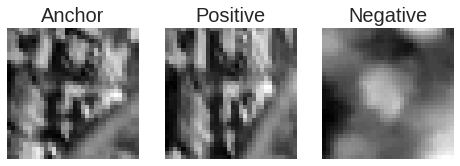

In [0]:
# Plot an example of triplet
plot_triplet(training_generator)

### Compile model

In [12]:
# Initialise random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Define the three input layers
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')

# Create the siamese models
baseline_descriptor_model = get_baseline_descriptor(shape)
ea = baseline_descriptor_model(xa)
ep = baseline_descriptor_model(xp)
en = baseline_descriptor_model(xn)

# Generate the triplet model
loss = Lambda(baseline_triplet_loss)([ea, ep, en])
baseline_descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)

# Compile model: SGD is rejected in favour of Adam even in the baseline model
adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=True)
baseline_descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=adm)

# Initialise lists to record training history
baseline_loss = []
baseline_val = []
baseline_epo = []
bs_epoch_count = 1

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


NameError: ignored

In [0]:
# Print a summary of the triplet model
baseline_descriptor_model_trip.summary()

## Train model

### Train and save model - Epoch 1
We obvserve running time and initial loss after the first epoch.

In [0]:
# Train first epoch
print('Epoch number',bs_epoch_count)
baseline_descriptor_hist = baseline_descriptor_model_trip.fit_generator(
                                                    generator=training_generator,
                                                    epochs=1, verbose=1,
                                                    validation_data=val_generator)
baseline_epo.append(bs_epoch_count)
baseline_loss.append(baseline_descriptor_hist.history['loss'])
baseline_val.append(baseline_descriptor_hist.history['val_loss'])
bs_epoch_count += 1

# Save models
baseline_descriptor_model_trip.save('bs_trip_descriptor_e1.h5')
baseline_descriptor_model.save('bs_descriptor_e1.h5')
!curl -F "file=@bs_trip_descriptor_e1.h5" https://file.io
!curl -F "file=@bs_descriptor_e1.h5" https://file.io

('Epoch number', 1)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2038

100%|██████████| 100000/100000 [00:03<00:00, 27345.47it/s]


2000/2000 [==============================] - 187s 94ms/step - loss: 0.2038 - val_loss: 0.1890
{"success":true,"key":"3TUCLq","link":"https://file.io/3TUCLq","expiry":"14 days"}{"success":true,"key":"ZhdBOs","link":"https://file.io/ZhdBOs","expiry":"14 days"}

### Train and save model - Epoch 5

In [0]:
for e in range(4):
  print('Epoch number',bs_epoch_count)
  
  baseline_descriptor_hist = baseline_descriptor_model_trip.fit_generator(
      generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  
  baseline_epo.append(bs_epoch_count)
  baseline_loss.append(baseline_descriptor_hist.history['loss'])
  baseline_val.append(baseline_descriptor_hist.history['val_loss'])
  bs_epoch_count += 1

# Save models
baseline_descriptor_model_trip.save('bs_trip_descriptor_e5.h5')
baseline_descriptor_model.save('bs_descriptor_e5.h5')
!curl -F "file=@bs_trip_descriptor_e5.h5" https://file.io
!curl -F "file=@bs_descriptor_e5.h5" https://file.io
  
# Print loss curves
print('Epochs',baseline_epo)
print('Loss', baseline_loss)
print('Val',baseline_val)

('Epoch number', 2)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1263

100%|██████████| 100000/100000 [00:03<00:00, 27412.30it/s]


2000/2000 [==============================] - 177s 88ms/step - loss: 0.1262 - val_loss: 0.1562
('Epoch number', 3)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1139

100%|██████████| 100000/100000 [00:03<00:00, 29031.63it/s]


2000/2000 [==============================] - 177s 88ms/step - loss: 0.1139 - val_loss: 0.1298
('Epoch number', 4)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1000

100%|██████████| 100000/100000 [00:04<00:00, 21855.52it/s]


2000/2000 [==============================] - 178s 89ms/step - loss: 0.1000 - val_loss: 0.1145
('Epoch number', 5)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0897

100%|██████████| 100000/100000 [00:03<00:00, 27346.04it/s]


2000/2000 [==============================] - 178s 89ms/step - loss: 0.0896 - val_loss: 0.1101
{"success":true,"key":"RvLkSP","link":"https://file.io/RvLkSP","expiry":"14 days"}{"success":true,"key":"PqhInI","link":"https://file.io/PqhInI","expiry":"14 days"}('Epochs', [1, 2, 3, 4, 5])
('Loss', [[0.20375348175376712], [0.12624182823907176], [0.11385689811104152], [0.09996190780464895], [0.08964496588223847]])
('Val', [[0.1890304999984801], [0.15621989610459422], [0.12979786690673792], [0.11447668469743803], [0.11011563445208594]])


### Train and save model - Epoch 20

In [0]:
for e in range(15):
  print('Epoch number',bs_epoch_count)
  
  baseline_descriptor_hist = baseline_descriptor_model_trip.fit_generator(
      generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  
  baseline_epo.append(bs_epoch_count)
  baseline_loss.append(baseline_descriptor_hist.history['loss'])
  baseline_val.append(baseline_descriptor_hist.history['val_loss'])
  bs_epoch_count += 1

# Save models
baseline_descriptor_model_trip.save('bs_trip_descriptor_e20.h5')
baseline_descriptor_model.save('bs_descriptor_e20.h5')
!curl -F "file=@bs_trip_descriptor_e20.h5" https://file.io
!curl -F "file=@bs_descriptor_e20.h5" https://file.io
  
# Print loss curves
print('Epochs',baseline_epo)
print('Loss', baseline_loss)
print('Val',baseline_val)

('Epoch number', 6)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0774

100%|██████████| 100000/100000 [00:03<00:00, 27373.61it/s]


2000/2000 [==============================] - 177s 89ms/step - loss: 0.0774 - val_loss: 0.1096
('Epoch number', 7)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0748

100%|██████████| 100000/100000 [00:03<00:00, 28913.38it/s]


2000/2000 [==============================] - 176s 88ms/step - loss: 0.0748 - val_loss: 0.1169
('Epoch number', 8)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0670

100%|██████████| 100000/100000 [00:03<00:00, 28409.79it/s]


2000/2000 [==============================] - 176s 88ms/step - loss: 0.0670 - val_loss: 0.0963
('Epoch number', 9)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0653

100%|██████████| 100000/100000 [00:03<00:00, 29365.07it/s]


2000/2000 [==============================] - 176s 88ms/step - loss: 0.0653 - val_loss: 0.1000
('Epoch number', 10)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0662

100%|██████████| 100000/100000 [00:03<00:00, 27736.00it/s]


2000/2000 [==============================] - 177s 88ms/step - loss: 0.0663 - val_loss: 0.0887
('Epoch number', 11)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0572

100%|██████████| 100000/100000 [00:04<00:00, 22279.27it/s]


2000/2000 [==============================] - 177s 89ms/step - loss: 0.0572 - val_loss: 0.1110
('Epoch number', 12)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0618

100%|██████████| 100000/100000 [00:03<00:00, 28499.19it/s]


2000/2000 [==============================] - 177s 89ms/step - loss: 0.0618 - val_loss: 0.1010
('Epoch number', 13)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0555

100%|██████████| 100000/100000 [00:03<00:00, 28035.26it/s]


2000/2000 [==============================] - 177s 88ms/step - loss: 0.0555 - val_loss: 0.0864
('Epoch number', 14)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0555

100%|██████████| 100000/100000 [00:03<00:00, 29135.94it/s]


2000/2000 [==============================] - 176s 88ms/step - loss: 0.0555 - val_loss: 0.0963
('Epoch number', 15)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0521

100%|██████████| 100000/100000 [00:03<00:00, 28367.89it/s]


2000/2000 [==============================] - 177s 89ms/step - loss: 0.0521 - val_loss: 0.0909
('Epoch number', 16)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0588

100%|██████████| 100000/100000 [00:03<00:00, 27399.01it/s]


2000/2000 [==============================] - 177s 88ms/step - loss: 0.0588 - val_loss: 0.0947
('Epoch number', 17)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0525

100%|██████████| 100000/100000 [00:03<00:00, 28533.68it/s]


2000/2000 [==============================] - 176s 88ms/step - loss: 0.0524 - val_loss: 0.0952
('Epoch number', 18)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0540

100%|██████████| 100000/100000 [00:04<00:00, 22711.76it/s]


2000/2000 [==============================] - 177s 88ms/step - loss: 0.0541 - val_loss: 0.0869
('Epoch number', 19)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0494

100%|██████████| 100000/100000 [00:03<00:00, 27402.02it/s]


2000/2000 [==============================] - 181s 91ms/step - loss: 0.0494 - val_loss: 0.0798


100%|██████████| 10000/10000 [00:00<00:00, 61407.77it/s]


('Epoch number', 20)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0484

100%|██████████| 100000/100000 [00:03<00:00, 27770.80it/s]


2000/2000 [==============================] - 179s 89ms/step - loss: 0.0484 - val_loss: 0.0831
{"success":true,"key":"6otRfC","link":"https://file.io/6otRfC","expiry":"14 days"}{"success":true,"key":"uUJYoA","link":"https://file.io/uUJYoA","expiry":"14 days"}('Epochs', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
('Loss', [[0.20375348175376712], [0.12624182823907176], [0.11385689811104152], [0.09996190780464895], [0.08964496588223847], [0.07738297405181584], [0.07480863291910646], [0.06696327244347049], [0.06532479770145619], [0.06626588492320479], [0.05716229805073635], [0.06180751825054722], [0.05546622675077015], [0.05546771268250086], [0.05212180319649815], [0.05879474075542885], [0.052441509388472696], [0.05406738201301778], [0.0494032579374234], [0.04835177053282405]])
('Val', [[0.1890304999984801], [0.15621989610459422], [0.12979786690673792], [0.11447668469743803], [0.11011563445208594], [0.10961331890663133], [0.11694466379005462], [0.096325404431263

## Rubbish

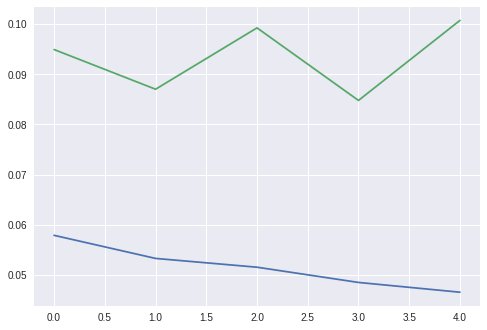

In [0]:
plt.plot(descriptor_history_xl.history['loss'])
plt.plot(descriptor_history_xl.history['val_loss'])

In [0]:
# Increase batch size to avoid reducing learning rate, also increase number of triplets exposed to the network
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)


### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames, use_clean=True)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=1000000,batch_size = 200)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=100000,batch_size = 200)


Using clean patches
100%|██████████| 116/116 [00:36<00:00,  3.22it/s]


100%|██████████| 1000000/1000000 [00:14<00:00, 68118.64it/s]


Using clean patches
100%|██████████| 116/116 [00:21<00:00,  5.44it/s]


100%|██████████| 100000/100000 [00:01<00:00, 62471.66it/s]


In [0]:
descriptor_history_xl = descriptor_model_trip.fit_generator(generator=training_generator, epochs=5, verbose=1, validation_data=val_generator)

## Further training

In [0]:
lol = hPatches.read_image_file(hpatches_dir, train=1)

In [0]:
np.shape(lol[1])

(1558960,)

In [0]:
np.shape(lol[0])

(1558960, 32, 32)

In [0]:
np.shape(lol[0][:10,:,:])

(10, 32, 32)

In [0]:
mol = tf.convert_to_tensor(np.random.rand(100,128))
print(mol.shape)
D = _pairwise_distances(mol, False)

In [0]:
np.mean(lol[0], axis = 0)

In [0]:
generator = DenoiseHPatches(['./hpatches/v_there'])
imgs, imgs_clean = next(iter(generator))
index = np.random.randint(0, imgs.shape[0])


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


In [0]:
a = next(iter(val_small_generator))

In [0]:
b = next(iter(val_small_generator))

In [0]:
b[1]

In [0]:
a[0]['p'].shape

(2000, 32, 32, 1)

# Train baseline Descriptor on denoised patches
To identify the upper bound performance of the baseline descriptor model as well as to gather qualitative insights on the network's output.

## Instantiate baseline descriptor model

### Load clean hpatches data

In [0]:
# Initialise random seeds for reproducibility
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Import and read hpatches dataset
hpatches_dir = './hpatches'
splits_path = './splits.json'
splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']
train_fnames = split['train']
test_fnames = split['test']
seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))


In [0]:
# Loading images
hPatches = HPatches(train_fnames=train_fnames, denoise_model=trained_denoiser, test_fnames=test_fnames, use_clean=False)

### Define model and loss

In [0]:
# Original L2-Net Baseline
def get_baseline_descriptor(shape):
  
  '''Architecture copies HardNet architecture'''
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  
  # Final descriptor reshape
  descriptor_model.add(Reshape((128,)))
  
  return descriptor_model

In [0]:
# Original triplet loss
def baseline_triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

### Create online generators

In [0]:
# Initialise random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Define baseline batch size and number of triplets
gen_batch_size = 50
trn_triplets = 100000
val_triplets =  10000

# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=trn_triplets)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=val_triplets)


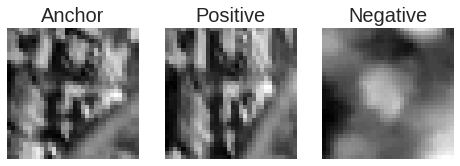

In [0]:
# Plot an example of triplet
plot_triplet(training_generator)

### Compile model

In [0]:
# Initialise random seeds
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Define the three input layers
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')

# Create the siamese models
baseline_descriptor_model = get_baseline_descriptor(shape)
ea = baseline_descriptor_model(xa)
ep = baseline_descriptor_model(xp)
en = baseline_descriptor_model(xn)

# Generate the triplet model
loss = Lambda(baseline_triplet_loss)([ea, ep, en])
baseline_descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)

# Compile model: SGD is rejected in favour of Adam even in the baseline model
adm = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=True)
baseline_descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=adm)

# Initialise lists to record training history
baseline_loss = []
baseline_val = []
baseline_epo = []
bs_epoch_count = 1

In [0]:
# Print a summary of the triplet model
baseline_descriptor_model_trip.summary()

## Train model

### Train and save model - Epoch 1
We obvserve running time and initial loss after the first epoch.

In [0]:
# Train first epoch
print('Epoch number',bs_epoch_count)
baseline_descriptor_hist = baseline_descriptor_model_trip.fit_generator(
                                                    generator=training_generator,
                                                    epochs=1, verbose=1,
                                                    validation_data=val_generator)
baseline_epo.append(bs_epoch_count)
baseline_loss.append(baseline_descriptor_hist.history['loss'])
baseline_val.append(baseline_descriptor_hist.history['val_loss'])
bs_epoch_count += 1

# Save models
baseline_descriptor_model_trip.save('dnbs_trip_descriptor_e1.h5')
baseline_descriptor_model.save('dnbs_descriptor_e1.h5')
!curl -F "file=@dnbs_trip_descriptor_e1.h5" https://file.io
!curl -F "file=@dnbs_descriptor_e1.h5" https://file.io

('Epoch number', 1)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2213

100%|██████████| 100000/100000 [00:04<00:00, 22832.47it/s]


2000/2000 [==============================] - 176s 88ms/step - loss: 0.2212 - val_loss: 0.2010
{"success":true,"key":"LcKSLr","link":"https://file.io/LcKSLr","expiry":"14 days"}{"success":true,"key":"PtiqPP","link":"https://file.io/PtiqPP","expiry":"14 days"}

In [0]:
bs_epoch_count

1

### Train and save model - Epoch 5

In [0]:
for e in range(4):
  print('Epoch number',bs_epoch_count)
  
  baseline_descriptor_hist = baseline_descriptor_model_trip.fit_generator(
      generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  
  baseline_epo.append(bs_epoch_count)
  baseline_loss.append(baseline_descriptor_hist.history['loss'])
  baseline_val.append(baseline_descriptor_hist.history['val_loss'])
  bs_epoch_count += 1

# Save models
baseline_descriptor_model_trip.save('dnbs_trip_descriptor_e5.h5')
baseline_descriptor_model.save('dnbs_descriptor_e5.h5')
!curl -F "file=@dnbs_trip_descriptor_e5.h5" https://file.io
!curl -F "file=@dnbs_descriptor_e5.h5" https://file.io
  
# Print loss curves
print('Epochs',baseline_epo)
print('Loss', baseline_loss)
print('Val',baseline_val)

('Epoch number', 2)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1541

 94%|█████████▍| 94066/100000 [00:03<00:00, 31169.07it/s]

2000/2000 [==============================] - 171s 86ms/step - loss: 0.1541 - val_loss: 0.1838


100%|██████████| 10000/10000 [00:00<00:00, 16706.57it/s]


('Epoch number', 3)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1389

 94%|█████████▍| 93907/100000 [00:03<00:00, 26442.93it/s]

2000/2000 [==============================] - 171s 86ms/step - loss: 0.1389 - val_loss: 0.1748


100%|██████████| 10000/10000 [00:00<00:00, 60206.50it/s]


('Epoch number', 4)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1270

 98%|█████████▊| 98198/100000 [00:03<00:00, 34765.76it/s]

2000/2000 [==============================] - 171s 86ms/step - loss: 0.1270 - val_loss: 0.1531


100%|██████████| 10000/10000 [00:00<00:00, 60122.19it/s]


('Epoch number', 5)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1173

 93%|█████████▎| 92627/100000 [00:03<00:00, 30022.26it/s]

2000/2000 [==============================] - 171s 86ms/step - loss: 0.1173 - val_loss: 0.1497


100%|██████████| 10000/10000 [00:00<00:00, 60729.72it/s]


{"success":true,"key":"kKE9pH","link":"https://file.io/kKE9pH","expiry":"14 days"}{"success":true,"key":"cpWDMC","link":"https://file.io/cpWDMC","expiry":"14 days"}('Epochs', [1, 2, 3, 4, 5])
('Loss', [[0.22122364778607154], [0.15412222058465705], [0.13891368479607627], [0.12695958790479928], [0.11728867068770342]])
('Val', [[0.20100265827029942], [0.18383058869279922], [0.17476918146945536], [0.15307056670077146], [0.1497141424147412]])


### Train and save model - Epoch 20

In [0]:
for e in range(15):
  print('Epoch number',bs_epoch_count)
  
  baseline_descriptor_hist = baseline_descriptor_model_trip.fit_generator(
      generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
  
  baseline_epo.append(bs_epoch_count)
  baseline_loss.append(baseline_descriptor_hist.history['loss'])
  baseline_val.append(baseline_descriptor_hist.history['val_loss'])
  bs_epoch_count += 1

# Save models
baseline_descriptor_model_trip.save('dnbs_trip_descriptor_e20.h5')
baseline_descriptor_model.save('dnbs_descriptor_e20.h5')
!curl -F "file=@dnbs_trip_descriptor_e20.h5" https://file.io
!curl -F "file=@dnbs_descriptor_e20.h5" https://file.io
  
# Print loss curves
print('Epochs',baseline_epo)
print('Loss', baseline_loss)
print('Val',baseline_val)

('Epoch number', 6)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1046

 83%|████████▎ | 83289/100000 [00:03<00:00, 32620.92it/s]

2000/2000 [==============================] - 173s 86ms/step - loss: 0.1046 - val_loss: 0.1521


100%|██████████| 10000/10000 [00:00<00:00, 12004.43it/s]


('Epoch number', 7)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1021

 97%|█████████▋| 97286/100000 [00:03<00:00, 31024.18it/s]

2000/2000 [==============================] - 171s 86ms/step - loss: 0.1021 - val_loss: 0.1522


100%|██████████| 10000/10000 [00:00<00:00, 60110.64it/s]


('Epoch number', 8)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0907

 94%|█████████▍| 93771/100000 [00:03<00:00, 28918.64it/s]

2000/2000 [==============================] - 171s 86ms/step - loss: 0.0907 - val_loss: 0.1382


100%|██████████| 10000/10000 [00:00<00:00, 36535.02it/s]


('Epoch number', 9)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0882

 92%|█████████▏| 92399/100000 [00:03<00:00, 32041.50it/s]

2000/2000 [==============================] - 172s 86ms/step - loss: 0.0882 - val_loss: 0.1326


100%|██████████| 10000/10000 [00:00<00:00, 60932.55it/s]


('Epoch number', 10)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0823

 93%|█████████▎| 93387/100000 [00:03<00:00, 31626.39it/s]

2000/2000 [==============================] - 172s 86ms/step - loss: 0.0823 - val_loss: 0.1678


100%|██████████| 10000/10000 [00:00<00:00, 34624.95it/s]


('Epoch number', 11)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0839

 95%|█████████▍| 94644/100000 [00:03<00:00, 30418.23it/s]

2000/2000 [==============================] - 172s 86ms/step - loss: 0.0839 - val_loss: 0.1579


100%|██████████| 10000/10000 [00:00<00:00, 59836.48it/s]


('Epoch number', 12)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0845

 89%|████████▉ | 89412/100000 [00:03<00:00, 31668.40it/s]

2000/2000 [==============================] - 172s 86ms/step - loss: 0.0846 - val_loss: 0.1357


100%|██████████| 10000/10000 [00:00<00:00, 21678.01it/s]


('Epoch number', 13)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0837

 91%|█████████ | 90905/100000 [00:03<00:00, 32486.82it/s]

2000/2000 [==============================] - 172s 86ms/step - loss: 0.0836 - val_loss: 0.1293


100%|██████████| 10000/10000 [00:00<00:00, 33180.71it/s]


('Epoch number', 14)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0773

 91%|█████████ | 90752/100000 [00:03<00:00, 29205.40it/s]

2000/2000 [==============================] - 172s 86ms/step - loss: 0.0772 - val_loss: 0.1308


100%|██████████| 10000/10000 [00:00<00:00, 17810.01it/s]


('Epoch number', 15)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0723

 98%|█████████▊| 97705/100000 [00:04<00:00, 29464.82it/s]

2000/2000 [==============================] - 171s 86ms/step - loss: 0.0723 - val_loss: 0.1407


100%|██████████| 10000/10000 [00:00<00:00, 60198.12it/s]


('Epoch number', 16)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0730

 97%|█████████▋| 96646/100000 [00:03<00:00, 30941.73it/s]

2000/2000 [==============================] - 173s 87ms/step - loss: 0.0729 - val_loss: 0.1302


100%|██████████| 10000/10000 [00:00<00:00, 59810.03it/s]


('Epoch number', 17)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0732

 96%|█████████▌| 95937/100000 [00:03<00:00, 27957.33it/s]

2000/2000 [==============================] - 172s 86ms/step - loss: 0.0732 - val_loss: 0.1300


100%|██████████| 10000/10000 [00:00<00:00, 61136.29it/s]


('Epoch number', 18)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0697

 92%|█████████▏| 92089/100000 [00:03<00:00, 29738.53it/s]

2000/2000 [==============================] - 172s 86ms/step - loss: 0.0696 - val_loss: 0.1165


100%|██████████| 10000/10000 [00:00<00:00, 33752.76it/s]


('Epoch number', 19)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0724

 94%|█████████▍| 94113/100000 [00:03<00:00, 30856.77it/s]

2000/2000 [==============================] - 171s 86ms/step - loss: 0.0724 - val_loss: 0.1142


100%|██████████| 10000/10000 [00:00<00:00, 61108.59it/s]


('Epoch number', 20)
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0669

100%|█████████▉| 99935/100000 [00:03<00:00, 27327.59it/s]

2000/2000 [==============================] - 171s 86ms/step - loss: 0.0670 - val_loss: 0.1201


100%|██████████| 10000/10000 [00:00<00:00, 57083.15it/s]


{"success":true,"key":"AI90R3","link":"https://file.io/AI90R3","expiry":"14 days"}{"success":true,"key":"p66azi","link":"https://file.io/p66azi","expiry":"14 days"}('Epochs', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
('Loss', [[0.22122364778607154], [0.15412222058465705], [0.13891368479607627], [0.12695958790479928], [0.11728867068770342], [0.10458592997015512], [0.10210923682362046], [0.0906655819955522], [0.08820582015627587], [0.08229035005806509], [0.083896127131502], [0.08455030574434204], [0.08364793859165912], [0.07722409284795503], [0.07227165060596781], [0.07292610311981435], [0.07321893805771833], [0.06962838557911163], [0.07236122024823453], [0.06695349532148248]])
('Val', [[0.20100265827029942], [0.18383058869279922], [0.17476918146945536], [0.15307056670077146], [0.1497141424147412], [0.15210309472400696], [0.15220730077475308], [0.13823029227554798], [0.13256005036644639], [0.16778525381349027], [0.1578529431950301], [0.13574334086384623], [

# Qualitative analysis of descriptor loss

In this section we visualise the individual pair distances onto the loss surface, the loss distribiution and the positive pair distances vs the negative pair distances.

### Generate the test triplets for qualitative evaluation

In [0]:
# Specify how many triplets to consider
n_triplets = 50000

random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)
# Generate a single large batch of triplets in the training set
eval_test_gen = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir,train=0), batch_size=n_triplets, num_triplets=n_triplets)




100%|██████████| 9525/9525 [13:29<00:00, 11.69it/s]



100%|██████████| 50000/50000 [00:00<00:00, 78612.38it/s]

In [0]:
# Plot PCA - tSNE of input patches

In [0]:
np.shape(eval_train_gen.data)

(1558960, 32, 32)

### Load model to evaluate

In [0]:
model_to_eval = keras.models.load_model('./dnbs_descriptor_e1.h5')
#model_to_evaltrip = keras.models.load_model('./bs_trip_descriptor_e5.h5')

### Calculate the distance between positive and negative descriptor pairs

Calculate the euclidean distance between AP, AN pairs. Then evaluate how the distance pairs are distributed onto the loss surface.

In [0]:
# Extract the triplets packed in the generator
a = next(iter(eval_test_gen))

# Generate the descriptor vectors for each anchor, positive and negative image
embedding_a = model_to_eval.predict(a[0]['a'])
embedding_p = model_to_eval.predict(a[0]['p'])
embedding_n = model_to_eval.predict(a[0]['n'])

# Measure distances between triplets
positive_distance = np.mean((embedding_a-embedding_p)**2 , axis=-1)
negative_distance = np.mean((embedding_a-embedding_n)**2 , axis=-1)

In [0]:
a = next(iter(eval_test_gen))

# Generate the descriptor vectors for each anchor, positive and negative image
embedding_a = model_to_eval.predict(a[0]['a'])
embedding_p = model_to_eval.predict(a[0]['p'])
embedding_n = model_to_eval.predict(a[0]['n'])

# Measure distances between triplets
positive_distance = np.mean((embedding_a-embedding_p)**2 , axis=-1)
negative_distance = np.mean((embedding_a-embedding_n)**2 , axis=-1)



<Figure size 144x360 with 0 Axes>

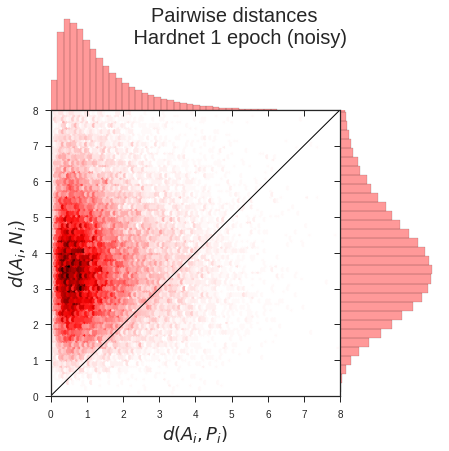

In [0]:
# Plot distance distribution
sns.set_style('ticks')
plt.figure(figsize=(2,5))
g = (sns.jointplot(x=positive_distance, y=negative_distance, kind="hex",color = 'r',
                   xlim = (0,8), ylim = (0,8), ratio = 3, space=0)
     .set_axis_labels("$d(A_i,P_i)$", "$d(A_i,N_i)$",fontsize=18))
g.ax_joint.legend_.remove()
g.fig.suptitle('Pairwise distances \n Hardnet 1 epoch (noisy)', fontsize=20)
g.ax_joint.plot([0,8], [0,8], 'k',linewidth = 1)

# Official evaluation metrics

## Generating descriptors files for test data 

To evaluate the performance of out model we will use an existing evaluation code, which is called HPatches benchmark. HPatches benchmark takes as input the descriptors for the test data in a CSV form. So the whole pipeline is represented in the following image.

![](https://i.ibb.co/WcDDf3q/Screenshot-from-2019-02-15-11-17-24.png)

This function generates those files by passing it a descriptor model and a denoising model. It performs a first step of denoising the patches, and a second one of computing the descriptor of the denoised patch. If no denoising model is given (variable set to `None`), the descriptor is computed directly in the noisy patch.

Similarly to the loading data part, you have the denoise_model variable and `use_clean` variable. If `use_clean` is set to True, the CSV generated will be those of the clean patches, even if a denoising model is given. If set to False, then depends on the variable `denoise_model`. If there is no denoise model (`denoise_model=None`), then it will use the noisy patches. If you give a denoising model, then it will compute the CSV for the denoised patches. This can be useful to explore different scenarios (for example, the Upper Bound can be training the descriptor network with clean patches, and testing with clean patches), however you should always report the score when using noisy patches (depending on the approach you develop, you may want to denoise them or not). The official baseline uses the denoised patches. 

In [0]:
generate_desc_csv(descriptor_model, seqs_test, use_clean=True)

100%|██████████| 40/40 [04:45<00:00,  7.62s/it]


## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model. 

**Updated**: The necessary code is included in the repository we cloned at the beginning of the code, so we do not need to download any extra data. Also, we simplified the results, so now they only return one value for each of the three tasks.

Now we will perform the evaluation of three different tasks (Verification, Matching and Evaluation) using the CSV files we generated as input and the `hpatches_eval.py` script. We also print the results using the `hpatches_results.py` script. The scripts will return a score for each of the tasks. The metric used is called mean Average Precision, which it uses the Precision of the model. The Precision is defined, for a given number of retrieved elements, as the ratio of correct retrieved elements / number of retrieved elements. [Link to Wikipedia with Precision explanation](https://en.wikipedia.org/wiki/Precision_and_recall). The definition of the three different tasks is taken from the [HPatches paper](https://arxiv.org/pdf/1704.05939.pdf).

In all of the tasks if you use the optional argument `--more_info` in `hpatches_results.py` you can see extra mAP information. However, the important score is the mAP score reported without this flag.

### Verification

Patch verification measures the ability of a descriptor to classify whether two patches are extracted from the same measurement. Now we compute the score of our architecture in this task.




In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:27<00:00, 11445.76it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:28<00:00, 11345.93it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:28<00:00, 11348.70it/s]
>> Verification task finished in 272 secs  
Verification task results:
Mean Average Precision is 0.505081




### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching


### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

## Compressing and saving the CSV files 

This is not necessary for the analysis of the baseline code included in the report. However, we will be hosting a competition in an external website to see who can achieve the highest score. In that case, you will need to submit the CSV files, as the scoring script will be performed in an external server. With that aim, we include here a way to save the files either in your local disc or in your google drive account.

We first compress the directory with all the CSV by using the following command. Remove the `q` option if you want it to output the progress.

In [0]:
!zip -rq descriptors.zip ./out/custom

The generated .zip is quite large, the method we used for the weights does not work. We have two other methods. First, in the file explorer in the left column we can right-click in the file and then click download. Then, we will see a circle next to the file showing the download progress.

The second way does not require for you to download the files, it save the zip file in your Google Drive account, and you can download it later to your machine if you want. To do so, follow this method (found [here](https://stackoverflow.com/questions/49428332/how-to-download-large-files-like-weights-of-a-model-from-colaboratory)). First run the next cell, and the output will be a link for authentication purposes, and just follow the instructions

In [0]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, 
                          mimetype='application/octet-stream',
                          resumable=True)

  created = drive_service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created


Now we can use the following function to save the file to your drive account. The second argument is the name of the file we want to save, and the first argument the name that will have in your Drive.

In [0]:
save_file_to_drive('descriptors_save.zip', 'descriptors.zip')

# Descriptor improvement

### Relu + BN method _rlbn

In [0]:
def S3Net(shape):
  '''
  Siamese Sigmoid activated Sine Loss Network
  Antonio Enas, 19/03/2019
  
  Based on L2-Net
  '''
  init_weights = keras.initializers.he_normal()
  
  inpt = Input(shape)
  
  # First convolutional filter  
  conv1 = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(inpt)
  conv1 = Activation('relu')(conv1)
  conv1 = BatchNormalization(axis = -1)(conv1)
  
  # Residual unit
  res = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights,strides=[1, 1])(conv1)
  res = Activation('relu')(res)
  res = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights,strides=[1, 1])(res)
  
  # Bottle-neck
  bottle = keras.layers.add([res,conv1])
  
  # Second convolutional filter  
  conv2 = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(bottle)
  conv2 = Activation('relu')(conv2)
  conv2 = BatchNormalization(axis = -1)(conv2)
  
  # Conv64/2
  conv3 = Conv2D(64, 3, padding='same', strides=2, use_bias = False, kernel_initializer=init_weights)(conv2)
  conv3 = Activation('relu')(conv3)
  conv3 = BatchNormalization(axis = -1)(conv3)
  
  # Conv64
  conv4 = Conv2D(64, 3, padding='same', use_bias = False, kernel_initializer=init_weights)(conv3)
  conv4 = Activation('relu')(conv4)
  conv4 = BatchNormalization(axis = -1)(conv4)

  # Conv128
  conv128 = Conv2D(128, 3, padding='same', strides=2,  use_bias = False, kernel_initializer=init_weights)(conv4)
  conv128 = Activation('relu')(conv128)
  conv128 = BatchNormalization(axis = -1)(conv128)

  conv128 = Conv2D(128, 3, padding='same', use_bias = False, kernel_initializer=init_weights)(conv128)
  conv128 = Activation('relu')(conv128)
  conv128 = BatchNormalization(axis = -1)(conv128)

  conv128 = Dropout(0.1)(conv128)
  conv128 = Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights)(conv128)
  
  out = Reshape((128,))(conv128)

  # Sigmoid function to constrain distances 0,1
  out = Activation('sigmoid')(out)
  
  s3net = Model(inputs = inpt, outputs = out)
  return s3net

## Experimental losses

In [0]:
# Reduced boundary triplet loss
def triplet_loss_up(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 0.5
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

In [0]:
# Lossless triplet loss
def triplet_loss_up(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 0.2
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  lossless = K.log(positive_distance+10+1e-18)-K.log(positive_distance+2+1e-18)
  
  return K.expand_dims(K.maximum(0.0, lossless), axis = 1)

In [0]:
# Sine loss
def triplet_loss_up(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 0.2
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  lossless = (1+positive_distance+1e-12)**2-negative_distance
  
  return K.expand_dims(lossless, axis = 1)

In [0]:
def triplet_loss_up(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 0.2
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  lossless = 1/(negative_distance+0.9)-1/(1.5+positive_distance)
  
  return K.expand_dims(K.maximum(0.0, lossless), axis = 1)

In [0]:
# Try Adadelta now
add = keras.optimizers.Adadelta(lr=1, rho=0.95, epsilon=None, decay=0.0)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=add)
descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)

# Classifier engine

In [0]:
def harsh_triplet_loss(x):
  
  # Margin
  
  
  # Unpack input
  a, p, n = x
  
  # Evaluate distances within batch
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  # Select only pair distances where AP<AN
  hard_mask = K.greater(negative_distance,negative_distance)
  
  # Identify hardest positive
  hardp = 
  
  # Identify hardest negative
  hardn = 
  
  hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
  
  
  return K.expand_dims(K.maximum(0.0, lossless), axis = 1)

In [0]:
def N_triplet_loss(x):
  
  # Margin
  _alpha = 1.0
  
  # Unpack input
  a, p, n = x
  
  # Evaluate distances within batch
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  # Count good pairs
  hard_mask = K.greater(negative_distance,negative_distance)
  
  # Adjusted triplet loss
  _adjusted_loss = (positive_distance - negative_distance + 1)/K.sum(hard_mask)
  
  return K.expand_dims(K.maximum(0.0, lossless), axis = 1)